## Install Dependencies

In [86]:
!pip install -q matplotlib numpy pandas pathlib seaborn
!pip install -q tensorflow 
!pip install -q git+https://github.com/tensorflow/docs

# !pip install -r -q requirements.txt

## Import Libraries

In [87]:
from __future__ import absolute_import, division, print_function, unicode_literals

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score

In [88]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers

assert float(tf.__version__.split(".", 1)[0]) >= 2.0, "Please use Tensorflow version 2!"
print(tf.__version__)

2.0.0


### Load the transformed data
Take the pkl file with extra feature columns into a dataframe

In [89]:
dataset = pd.read_pickle('output/training_set_rel3.pkl')
dataset

,essay_set,essay,domain1_score,essay_length,avg_sentence_length,avg_word_length,sentiment,noun_phrases,syntax_errors,readability_index,difficult_words
8074,5,"In the memoir, ""Narciso Rodriguez"" by Narciso ...",4,231.0,16.357143,4.471861,0.082832,12.0,12.0,11.0,26.0
10912,7,The time I was patience was when I was @NUM1 y...,16,23.0,23.000000,4.608696,0.000000,1.0,0.0,12.0,5.0
6,1,Did you know that more and more people these d...,10,43.0,14.333333,4.395349,0.027083,2.0,2.0,6.8,5.0
6767,4,The author concludes the story with he paragra...,1,411.0,21.473684,4.990268,0.250740,48.0,14.0,14.3,59.0
4441,3,There are many ways that the features of the s...,2,87.0,43.500000,4.022989,-0.152778,4.0,4.0,19.8,6.0
...,...,...,...,...,...,...,...,...,...,...,...
1762,1,"Guaranteed, @NUM1 years from now we will still...",9,189.0,18.600000,4.455026,0.406000,17.0,10.0,11.0,25.0
1522,1,"Dear @CAPS1 @CAPS2 @CAPS3, @CAPS4 many people ...",10,73.0,14.600000,4.534247,0.123333,7.0,4.0,7.7,12.0
296,1,"Dear local Newspaper, I assume you've heard ab...",9,30.0,10.000000,3.566667,0.102778,2.0,1.0,0.9,2.0
1632,1,"To @CAPS1 @CAPS2 @ORGANIZATION1, Computers are...",8,166.0,27.000000,4.114458,0.029167,8.0,18.0,25.8,10.0


Inspect Columns

In [90]:
dataset.dtypes

essay_set                int64
essay                   object
domain1_score            int64
essay_length           float64
avg_sentence_length    float64
avg_word_length        float64
sentiment              float64
noun_phrases           float64
syntax_errors          float64
readability_index      float64
difficult_words        float64
dtype: object

In [91]:
dataset.isna().sum() > 0 

essay_set              False
essay                  False
domain1_score          False
essay_length           False
avg_sentence_length    False
avg_word_length        False
sentiment              False
noun_phrases           False
syntax_errors          False
readability_index      False
difficult_words        False
dtype: bool

>You must extract a minimum of three different types of features.

Please see `data_etl.ipynb` for details.
```
meta_features = ['essay_length', 'avg_sentence_length', 'avg_word_length']
grammar_features = ['sentiment', 'noun_phrases', 'syntax_errors']
redability_features = ['readability_index', 'difficult_words']
```

In [92]:
# dataset = dataset.dropna(axis='columns').drop(columns=['essay', 'essay_set'])
dataset = dataset.dropna(axis='columns').drop(columns=['essay'])

In [112]:
def get_feature_combinations(dataset):
    attributes = list(dataset)
    attributes.remove('domain1_score')

    attribute_combinations = []
    for size in range(len(attributes)):
        attribute_combinations = attribute_combinations + list(itertools.combinations(attributes, size + 1))

    return attribute_combinations

get_feature_combinations(dataset)

[('essay_set',),
 ('essay_length',),
 ('avg_sentence_length',),
 ('avg_word_length',),
 ('sentiment',),
 ('noun_phrases',),
 ('syntax_errors',),
 ('readability_index',),
 ('difficult_words',),
 ('essay_set', 'essay_length'),
 ('essay_set', 'avg_sentence_length'),
 ('essay_set', 'avg_word_length'),
 ('essay_set', 'sentiment'),
 ('essay_set', 'noun_phrases'),
 ('essay_set', 'syntax_errors'),
 ('essay_set', 'readability_index'),
 ('essay_set', 'difficult_words'),
 ('essay_length', 'avg_sentence_length'),
 ('essay_length', 'avg_word_length'),
 ('essay_length', 'sentiment'),
 ('essay_length', 'noun_phrases'),
 ('essay_length', 'syntax_errors'),
 ('essay_length', 'readability_index'),
 ('essay_length', 'difficult_words'),
 ('avg_sentence_length', 'avg_word_length'),
 ('avg_sentence_length', 'sentiment'),
 ('avg_sentence_length', 'noun_phrases'),
 ('avg_sentence_length', 'syntax_errors'),
 ('avg_sentence_length', 'readability_index'),
 ('avg_sentence_length', 'difficult_words'),
 ('avg_word_l

In [94]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [95]:
train_stats = train_dataset.describe().pop("domain1_score").transpose()
train_stats

count    10381.000000
mean         6.716405
std          8.891451
min          0.000000
25%          2.000000
50%          3.000000
75%          8.000000
max         60.000000
Name: domain1_score, dtype: float64

In [96]:
train_labels = train_dataset.pop('domain1_score')
test_labels = test_dataset.pop('domain1_score')

In [97]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data

,essay_set,essay_length,avg_sentence_length,avg_word_length,sentiment,noun_phrases,syntax_errors,readability_index,difficult_words
2976,-0.530443,10.828783,3.106009,-0.225797,-0.757252,0.256830,0.144363,1.302779,1.269039
1324,-0.642910,71.111404,1.931348,-0.281923,-0.729901,2.843585,1.718909,0.740441,2.843585
12143,0.031895,53.116591,0.809245,-0.237416,-0.732906,2.731117,0.256830,0.144363,8.017093
3803,-0.417975,14.315277,1.381506,-0.266899,-0.751680,0.594233,0.144363,0.256830,1.156571
252,-0.642910,93.942322,0.600481,-0.270512,-0.741380,12.065926,3.068520,0.234337,8.129561
...,...,...,...,...,...,...,...,...,...
3355,-0.530443,39.508015,1.375587,-0.327184,-0.739280,2.731117,3.293455,0.346804,1.269039
6542,-0.305507,9.029301,0.642434,-0.309386,-0.748951,-0.193040,0.481766,-0.260520,0.256830
4225,-0.417975,6.330080,0.661714,-0.294796,-0.727261,-0.417975,-0.642910,-0.249274,-0.305507
6479,-0.305507,47.830615,1.056600,-0.234695,-0.739356,2.056312,0.369298,0.403038,4.755533


In [98]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [99]:
model = build_model()

In [100]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [101]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 2.5179029],
       [15.623663 ],
       [12.137756 ],
       [ 3.2502847],
       [20.479496 ],
       [ 2.6699939],
       [ 3.4960928],
       [ 2.5713978],
       [ 6.2497005],
       [ 3.9603148]], dtype=float32)

In [102]:
model = build_model()

EPOCHS = 1000
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:80.5847,  mae:5.6110,  mse:80.5847,  val_loss:74.0108,  val_mae:5.6114,  val_mse:74.0108,  
....................................................................................................
Epoch: 100, loss:5.9622,  mae:1.4214,  mse:5.9622,  val_loss:6.4593,  val_mae:1.5959,  val_mse:6.4593,  
....................................................................................................
Epoch: 200, loss:5.3566,  mae:1.3723,  mse:5.3566,  val_loss:5.4534,  val_mae:1.4110,  val_mse:5.4534,  
....................................................................................................
Epoch: 300, loss:5.0835,  mae:1.3342,  mse:5.0835,  val_loss:5.7658,  val_mae:1.4457,  val_mse:5.7658,  
............

In [103]:
hist = pd.DataFrame(early_history.history)
hist['epoch'] = early_history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
307,5.039297,1.333754,5.039298,6.490976,1.494451,6.490976,307
308,5.077600,1.341877,5.077598,5.928021,1.441738,5.928021,308
309,5.063305,1.338954,5.063303,5.888891,1.458616,5.888891,309
310,5.043942,1.328696,5.043941,6.003290,1.461893,6.003289,310
311,5.026554,1.331606,5.026555,5.819243,1.457323,5.819243,311


In [104]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [domain1_score]')

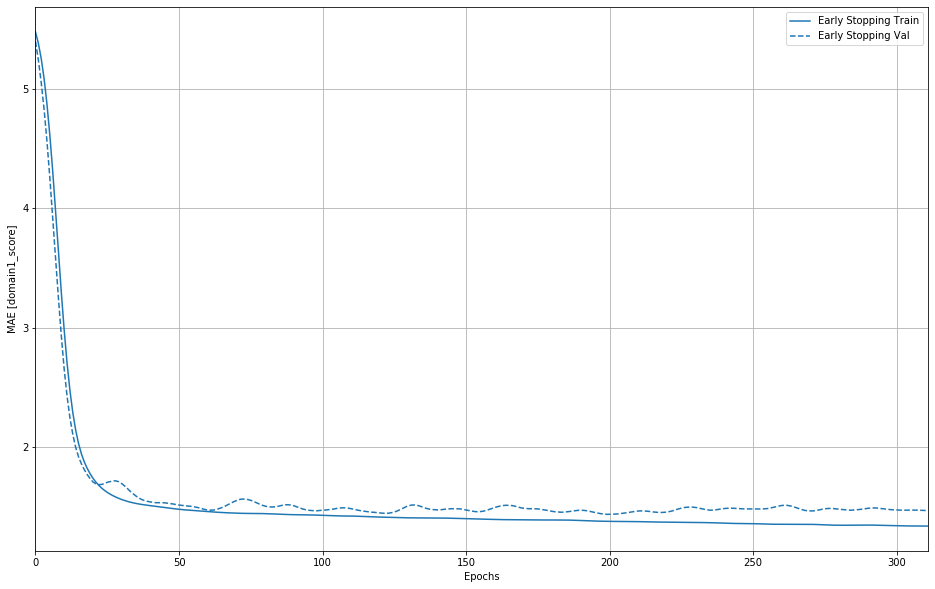

In [105]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylabel('MAE [domain1_score]')

Text(0, 0.5, 'MSE [domain1_score^2]')

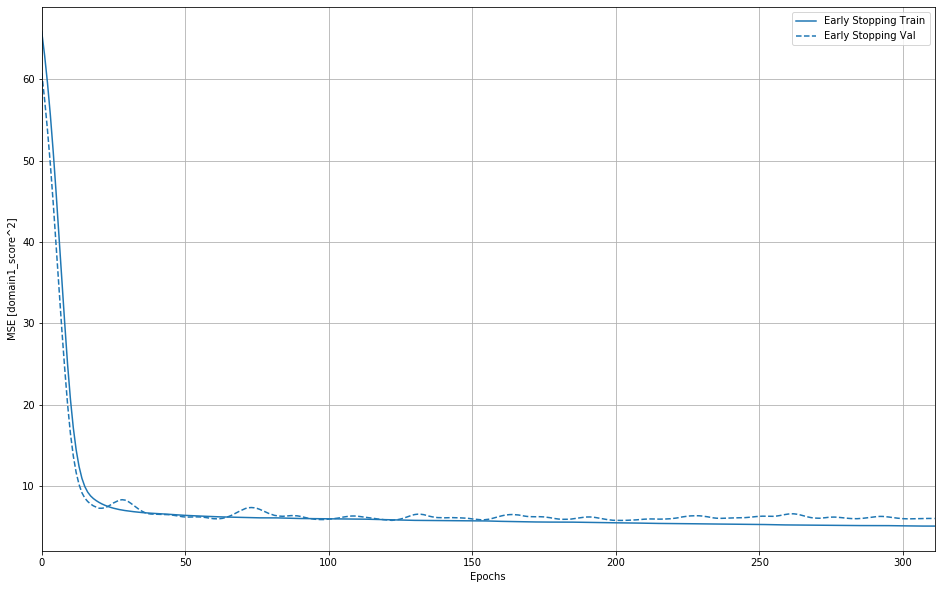

In [106]:
plotter.plot({'Early Stopping': early_history}, metric = "mse")
plt.ylabel('MSE [domain1_score^2]')

In [107]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} domain1_score".format(mae))

2595/2595 - 0s - loss: 5.8124 - mae: 1.4965 - mse: 5.8124
Testing set Mean Abs Error:  1.50 domain1_score


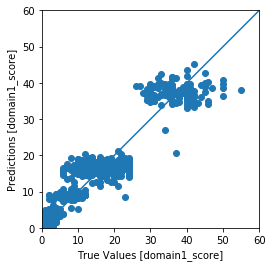

In [108]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [domain1_score]')
plt.ylabel('Predictions [domain1_score]')
lims = [0, 60]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


>You should evaluate your system’s performance overall and for each subset of test essays using quadratic weighted kappa (https://www.kaggle.com/c/asap-aes/overview/evaluation).

A weighted Kappa cab be used to calculate the similarity between predicted and actual score. A perfect score of close to 1.0 is granted when both the predictions and actuals are the same.
Whereas, the least possible score is -1 which is given when the predictions are furthest away from actuals. 

In [109]:
result = cohen_kappa_score(test_labels.values, test_predictions.astype(int), weights='quadratic')
result

0.9639417746039599

>You should compare the performance of your model to (at least) a baseline that predicts a random class for each test essay.

In [110]:
random_predictions = np.random.uniform(low=0, high=test_labels.values.max(), size=test_predictions.size)
baseline = cohen_kappa_score(test_labels.values, random_predictions.astype(int), weights='quadratic')
baseline

0.016571317210290926

In [111]:
pct = (result-baseline)/baseline * 100
print("Model performed {0}% better than the baseline (random scoring).".format(pct))

Model performed 5716.92910932478 better than the baseline (random scoring).
